In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

C:\Users\walsa\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\walsa\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\walsa\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 

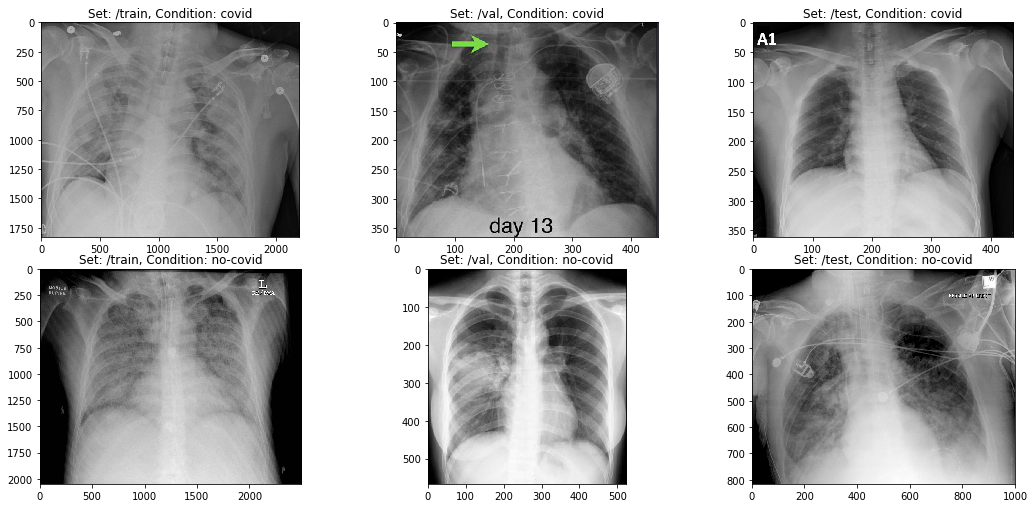

In [2]:
input_path = 'selectedData/image2class'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['/train','/val', '/test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/covid/'+os.listdir(set_path+'/covid')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: covid'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/no-covid/'+os.listdir(set_path+'/no-covid')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: no-covid'.format(_set))

In [3]:
for _set in ['/train', '/val', '/test']:
    covid = len(os.listdir(input_path + _set + '/covid'))
    no_covid = len(os.listdir(input_path + _set + '/no-covid'))
    print('Set: {}, covid images: {}, no-covid images: {}'.format(_set, covid, no_covid))

Set: /train, covid images: 33, no-covid images: 33
Set: /val, covid images: 31, no-covid images: 4
Set: /test, covid images: 15, no-covid images: 9


In [4]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'/train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'/test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/covid/', '/no-covid/']:
        for img in (os.listdir(input_path + '/test' + cond)):
            img = plt.imread(input_path+'/test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/covid/':
                label = 0
            elif cond=='/no-covid/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    #test_data = np.array(test_data)
    #test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [5]:
img_dims = 224
epochs = 20
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 66 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [6]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=10,#train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=10,#test_gen.samples // batch_size, 
           callbacks=[checkpoint, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
10/10 [==============================] - 66s 7s/step - loss: 0.6943 - acc: 0.4509 - val_loss: 0.6728 - val_acc: 0.6250
Epoch 2/20
10/10 [==============================] - 43s 4s/step - loss: 0.7006 - acc: 0.5361 - val_loss: 0.6683 - val_acc: 0.6250
Epoch 3/20
10/10 [==============================] - 40s 4s/step - loss: 0.7043 - acc: 0.4310 - val_loss: 0.6764 - val_acc: 0.6250
Epoch 4/20
10/10 [==============================] - 44s 4s/step - loss: 0.7092 - acc: 0.4310 - val_loss: 0.6748 - val_acc: 0.6250
Epoch 5/20
10/10 [==============================] - 46s 5s/step - loss: 0.6930 - acc: 0.5717 - val_loss: 0.6739 - val_acc: 0.6250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
10/10 [==============================] - 39s 4s/step - loss: 0.6938 - acc: 0.6083 - val_loss: 0.6902 - val_acc: 0.6250
Epoch 7/20
10/10 [==============================] - 49s 5s/step - loss: 0.6977 - acc: 0.496

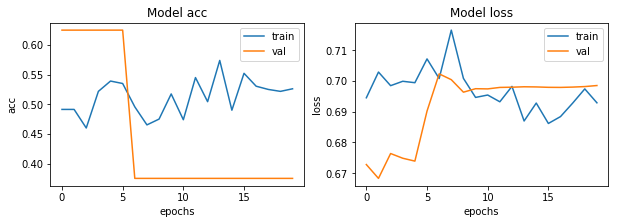

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 24 arrays: [array([[[9.45456341e-05, 9.45456341e-05, 9.45456341e-05, ...,
         9.45456341e-05, 9.45456341e-05, 3.92156886e-03],
        [9.70093970e-05, 9.70093970e-05, 9.70093970e-05, ...,
         9.700939...